<a href="https://colab.research.google.com/github/askolesov0608/CV_NV/blob/main/99CVLab3_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and setup

In [ ]:
pip install --upgrade imageio

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from google.colab import files

In [3]:
!cp /content/gdrive/MyDrive/CV/Lab3/visualPercepUtils.py /content #copy file

In [4]:
!cp -r /content/gdrive/MyDrive/CV/Lab3/ /content #copy all folder

In [5]:
from PIL import Image
from scipy.ndimage import filters
import numpy.fft as fft
from scipy.signal import medfilt2d
import numpy as np
import matplotlib.pyplot as plt
import math as math
import os
import sys

import glob # Модуль для поиска файлов в директориях с помощью шаблонов в Unix стиле. Например, glob.glob('*.png')
import visualPercepUtils as vpu

In [6]:
#files.upload()

# Code provided from the teacher

## Inputs

In [17]:
#пути к директориям для входных и выходных файлов.
path_input = './Lab3/imgs-P3/'
path_output = './Lab3/imgs-out-P3/'

In [18]:
ls

gdrive/  Lab3/  __pycache__/  sample_data/  visualPercepUtils.py


In [19]:
# Получаем список файлов в директории
files = os.listdir(path_input)

# Выводим список файлов
for file in files:
    print(file)

einstein.jpg
lena255.pgm
b.pgm
a.pgm
habas.pgm
stp1.gif
positions.p
stp2.gif
mimbre.pgm


## Fourier Transform

In [20]:
# ----------------------
# Fourier Transform
# ----------------------

def FT(im):
    # https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html
    return fft.fftshift(fft.fft2(im))  # perform also the shift to have lower frequencies at the center


def IFT(ft):
    return fft.ifft2(fft.ifftshift(ft))  # assumes ft is shifted and therefore reverses the shift before IFT


def testFT(im, params=None):
    ft = FT(im)
    #print(ft.shape)
    phase = np.angle(ft)
    magnitude = np.log(np.absolute(ft))
    bMagnitude = True
    if bMagnitude:
        im2 = np.absolute(IFT(ft))  # IFT consists of complex number. When applied to real-valued data the imaginary part should be zero, but not exactly for numerical precision issues
    else:
        im2 = np.real(IFT(ft)) # with just the module we can't appreciate the effect of a shift in the signal (e.g. if we use fftshift but not ifftshift, or viceversa)
        # Important: one case where np.real() is appropriate but np.absolute() is not is where the sign in the output is relevant
    return [magnitude, phase, im2]

## Convolution theorem

In [21]:
# -----------------------
# Convolution theorem
# -----------------------

# the mask corresponding to the average (mean) filter
def avgFilter(filterSize):
    mask = np.ones((filterSize, filterSize))
    return mask/np.sum(mask)

In [22]:
# apply average filter in the spatial domain
def averageFilterSpace(im, filterSize):
    return filters.convolve(im, avgFilter(filterSize))

In [23]:
# apply average filter in the frequency domain
def averageFilterFrequency(im, filterSize):
    filterMask = avgFilter(filterSize)  # the usually small mask
    filterBig = np.zeros_like(im, dtype=float)  # as large as the image (dtype is important here!)

    # Now, place filter (the "small" filter mask) at the center of the "big" filter

    ## First, get sizes
    w, h = filterMask.shape
    w2, h2 = w / 2, h / 2  # half width and height of the "small" mask
    W, H = filterBig.shape
    W2, H2 = W / 2, H / 2  # half width and height of the "big" mask

    ## Then, paste the small mask at the center using the sizes computed before as an aid
    filterBig[int(W2 - w2):int(W2 + w2), int(H2 - h2):int(H2 + h2)] = filterMask

    # FFT of the big filter
    filterBig = fft.ifftshift(filterBig)  # shift origin at upper-left corner

    # Finally, IFT of the element-wise product of the FT's
    return np.absolute(IFT(FT(im) * FT(filterBig)))  # both '*' and multiply() perform elementwise product

In [24]:
def testConvTheo(im, params=None):
    filterSize = params['filterSize']

    # image filtered with a convolution in spatial domain
    imFiltSpace = averageFilterSpace(im, filterSize)

    # image filtered in frequency domain
    imFiltFreq = averageFilterFrequency(im, filterSize)

    # How much do they differ?
    # To quantify the difference, we use the Root Mean Square Measure (https://en.wikipedia.org/wiki/Root_mean_square)
    margin = 5  # exclude some outer pixels to reduce the influence of border effects
    rms = np.linalg.norm(imFiltSpace[margin:-margin, margin:-margin] - imFiltFreq[margin:-margin, margin:-margin], 2) / np.prod(im.shape)
    print("Images filtered in space and frequency differ in (RMS):", rms)

    return [imFiltSpace, imFiltFreq]

## High-, low- and band-pass filters

In [25]:
# -----------------------------------
# High-, low- and band-pass filters
# -----------------------------------

# generic band-pass filter (both, R and r, given) which includes the low-pass (r given, R not)
# and the high-pass (R given, r not) as particular cases
def bandPassFilter(shape, r=None, R=None):
    n, m = shape
    m2, n2 = np.floor(m / 2.0), np.floor(n / 2.0)
    [vx, vy] = np.meshgrid(np.arange(-m2, m2 + 1), np.arange(-n2, n2 + 1))
    distToCenter = np.sqrt(vx ** 2.0 + vy ** 2.0)
    if R is None:  # low-pass filter assumed
        assert r is not None, "at least one size for filter is expected"
        filter = distToCenter<r # same as np.less(distToCenter, r)
    elif r is None:  # high-pass filter assumed
        filter = distToCenter>R # same as np.greater(distToCenter, R)
    else:  # both, R and r given, then band-pass filter
        if r > R:
            r, R = R, r  # swap to ensure r < R (alternatively, warn the user, or throw an exception)
        filter = np.logical_and(distToCenter<R, distToCenter>r)
    filter = filter.astype('float')  # convert from boolean to float. Not strictly required

    bDisplay = True
    if bDisplay:
        plt.imshow(filter, cmap='gray')
        plt.show()
        plt.title("The filter in the frequency domain")
        # Image.fromarray((255*filter).astype(np.uint8)).save('filter.png')

    return filter

In [26]:
def testBandPassFilter(im, params=None):
    r, R = params['r'], params['R']
    filterFreq = bandPassFilter(im.shape, r, R)  # this filter is already in the frequency domain
    filterFreq = fft.ifftshift(filterFreq)  # shifting to have the origin as the FT(im) will be
    return [np.absolute(fft.ifft2(filterFreq * fft.fft2(im)))]  # the filtered image

## Test image files

In [27]:
# -----------------
# Test image files
# -----------------
path_input = './Lab3/imgs-P3/'
path_output = './Lab3/imgs-out-P3/'
bAllFiles = False
if bAllFiles:
    files = glob.glob(path_input + "*.pgm")
else:
    files = [path_input + 'einstein.jpg']  # lena255, habas, mimbre

## Tests to perform

In [28]:
# --------------------
# Tests to perform
# --------------------
bAllTests = True
if bAllTests:
    tests = ['testFT', 'testConvTheo', 'testBandPassFilter']
else:
    tests = ['testFT']
    tests = ['testConvTheo']
    tests = ['testBandPassFilter']

## Dictionary of user-friendly names for each function ("test") name

In [29]:
# -------------------------------------------------------------------
# Dictionary of user-friendly names for each function ("test") name
# -------------------------------------------------------------------

nameTests = {'testFT': '2D Fourier Transform',
             'testConvTheo': 'Convolution Theorem (tested on mean filter)',
             'testBandPassFilter': 'Frequency-based filters ("high/low/band-pass")'
             }

bSaveResultImgs = False

testsUsingPIL = []  # which test(s) uses PIL images as input (instead of NumPy 2D arrays)

## Apply defined tests and display results

Testing on ['./Lab3/imgs-P3/einstein.jpg']
# images 3
3
4 None None


<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-30-a6cf204ba6b6>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if test is "testFT":
<ipython-input-30-a6cf204ba6b6>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif test is "testConvTheo":


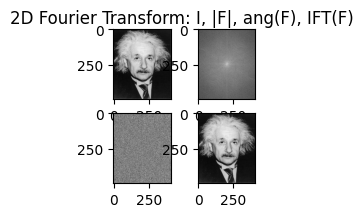

<ipython-input-22-e41b61d947f4>:3: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  return filters.convolve(im, avgFilter(filterSize))


Images filtered in space and frequency differ in (RMS): 0.0010838837670750028
# images 2
2
3 None None


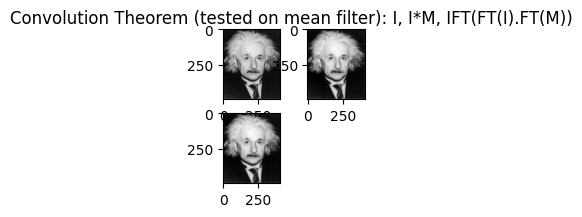

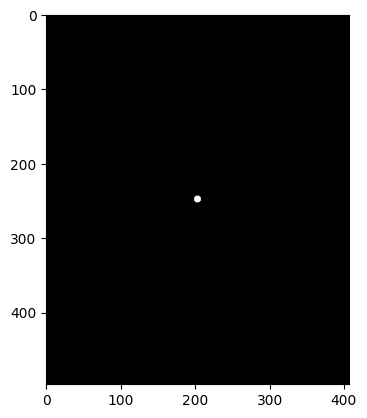

# images 1
1
2 None None


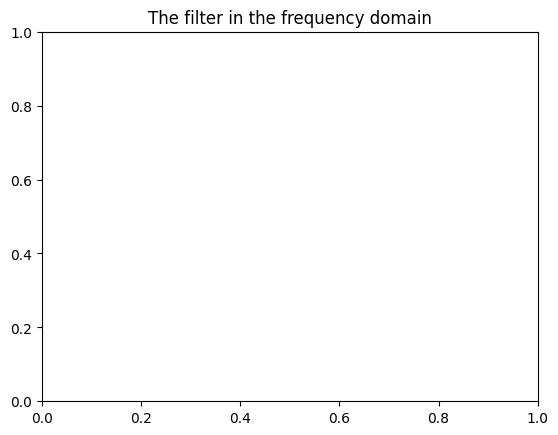

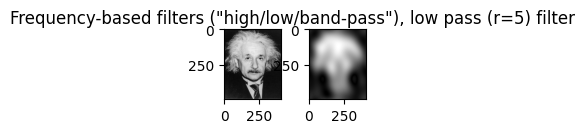

In [30]:
# -----------------------------------------
# Apply defined tests and display results
# -----------------------------------------

def doTests():
    print("Testing on", files)
    for imfile in files:
        im_pil = Image.open(imfile).convert('L')
        im = np.array(im_pil)  # from Image to array

        for test in tests:
            if test is "testFT":
                params = {}
                subTitle = ": I, |F|, ang(F), IFT(F)"
            elif test is "testConvTheo":
                params = {}
                params['filterSize'] = 7
                subTitle = ": I, I*M, IFT(FT(I).FT(M))"
            else:
                params = {}
                r,R = 5,None # for low-pass filter
                # 5,30 for band-pass filter
                # None, 30 for high-pass filter
                params['r'], params['R'] = r,R
                # let's assume r and R are not both None simultaneously
                if r is None:
                    filter="high pass" + " (R=" + str(R) + ")"
                elif R is None:
                    filter="low pass" + " (r=" + str(r) + ")"
                else:
                    filter="band pass" + " (r=" + str(r) + ", R=" + str(R) + ")"
                subTitle = ", " + filter + " filter"

            if test in testsUsingPIL:
                outs_pil = eval(test)(im_pil, params)
                outs_np = vpu.pil2np(outs_pil)
            else:
                # apply test to given image and given parameters
                outs_np = eval(test)(im, params)
            print("# images", len(outs_np))
            print(len(outs_np))

            vpu.showInGrid([im] + outs_np, title=nameTests[test] + subTitle)


if __name__ == "__main__":
    doTests()

# Testing directory and loads

In [31]:
ls

gdrive/  Lab3/  __pycache__/  sample_data/  visualPercepUtils.py


In [32]:
folder_path = './Lab3/imgs-P3/'
path_output = './Lab3/imgs-out-P3/'


In [33]:
# Получаем список файлов в директории
files = os.listdir(folder_path)

# Выводим список файлов
for file in files:
    print(file)

einstein.jpg
lena255.pgm
b.pgm
a.pgm
habas.pgm
stp1.gif
positions.p
stp2.gif
mimbre.pgm


In [34]:
filename = "einstein.jpg"

In [35]:
path_input = os.path.join(folder_path, filename)

In [36]:
test_image = Image.open(path_input)
print(test_image.size)

(407, 497)


array([[125,  82,  83, ...,  99,  91, 147],
       [ 83,  36,  31, ...,  38,  31,  88],
       [ 85,  34,  25, ...,  36,  30,  87],
       ...,
       [ 97,  56,  82, ...,  20,  31,  89],
       [102,  62,  71, ...,  19,  30,  88],
       [157, 130, 137, ..., 131, 132, 147]], dtype=uint8)
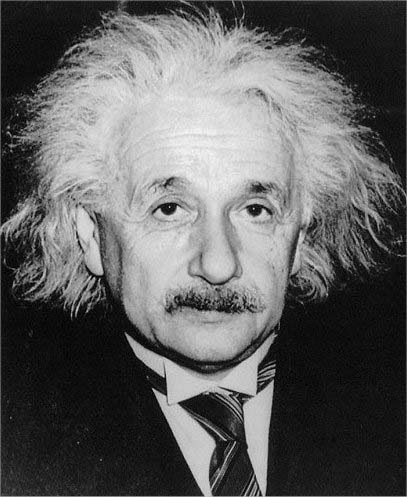

In [37]:
im = np.array(test_image.convert('L'))
im

# Ex Question 1 Fourier Transform compute

## FFT

### Testing

Для начала необходимо выполнить само преобразование, затем измерить амплитуду на каждой частоте и выбрать наименьшую и наибольшую из них. f(t)=sin(2π⋅10t)+0.5sin(2π⋅20t) Этот сигнал представляет собой сумму двух синусоидальных волн с частотами 10 Гц и 20 Гц.

In [28]:
# Параметры сигнала
Fs = 100  # Частота дискретизации
T = 1    # длительность сигнала в секундах

t = np.linspace(0, T, int(Fs*T), endpoint=False)  # Временная ось
                      #Fs*T — умножение

#np.linspace из библиотеки NumPy используется для генерации равномерно распределенных чисел в заданном интервале.
  #Прототип функции выглядит так: np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
  #num — количество генерируемых точек (по умолчанию 50).
  #endpoint — логический флаг, указывающий, включать ли конечное значение
  #retstep — если установлено в True, функция также возвращает шаг между соседними значениями.
  #dtype — тип данных выходного массива.
  #axis — ось вдоль которой располагаются значения (применимо в многомерных массивах).

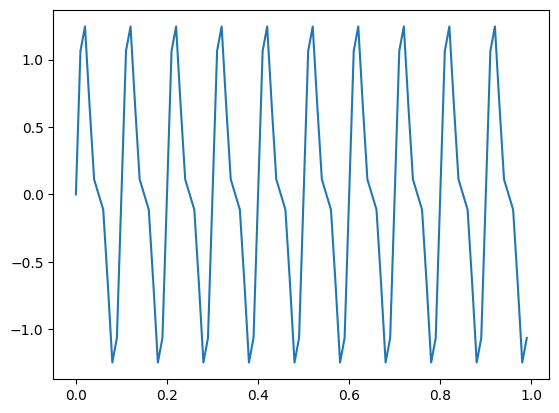

In [29]:
# Создание сигнала
signal = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*20*t)
plt.plot(t, signal)

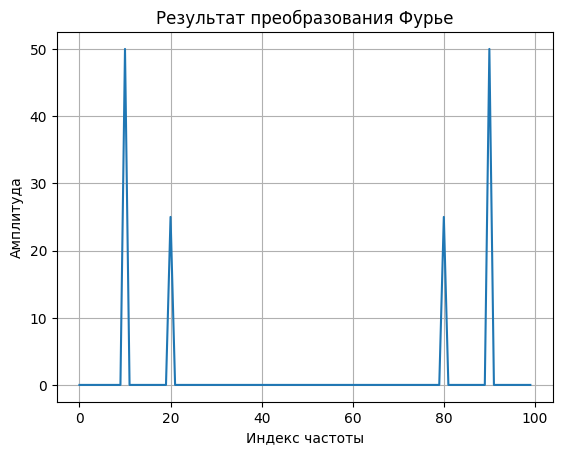

In [30]:
# Фурье-преобразование
fft_result = np.fft.fft(signal)

# Построение графика
plt.plot(np.abs(fft_result))
plt.xlabel('Индекс частоты')
plt.ylabel('Амплитуда')
plt.title('Результат преобразования Фурье')
plt.grid(True)
plt.show()

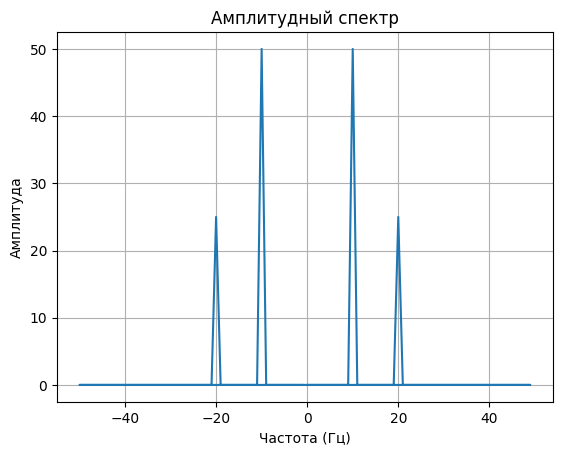

In [31]:
frequencies = np.fft.fftfreq(len(t), 1/Fs)

# Построение графика
plt.plot(frequencies, np.abs(fft_result))
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.title('Амплитудный спектр')
plt.grid(True)
plt.show()

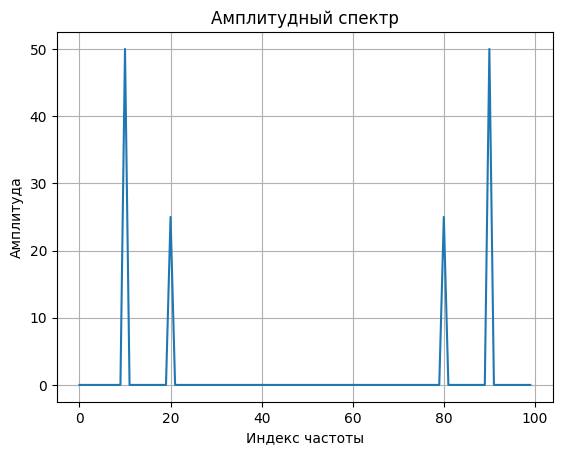

In [32]:
# Вычисление амплитуд
magnitudes = np.abs(fft_result)

# Построение графика
plt.plot(magnitudes)
plt.xlabel('Индекс частоты')
plt.ylabel('Амплитуда')
plt.title('Амплитудный спектр')
plt.grid(True)
plt.show()

#magnitudes

In [33]:
# Нахождение наименьшей и наибольшей амплитуды
lowest_magnitude = np.min(magnitudes)
highest_magnitude = np.max(magnitudes)
print("Lowerst", lowest_magnitude)
print("Highest", highest_magnitude)

Lowerst 7.273603118493526e-16
Highest 50.0


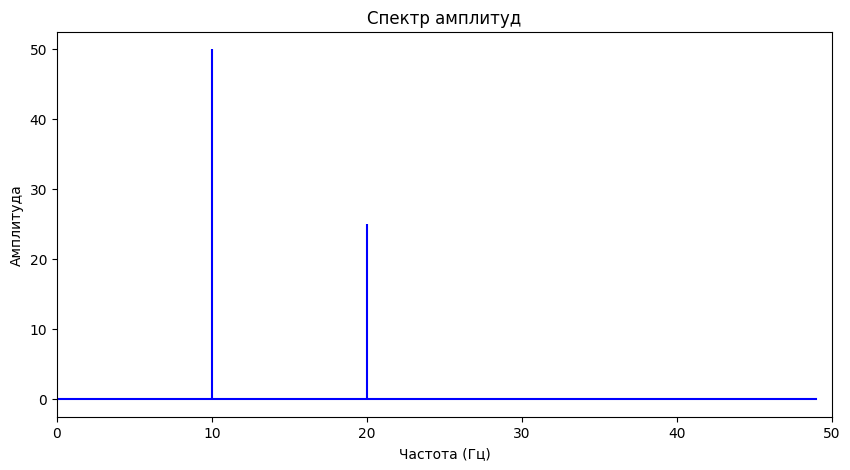

In [34]:
# График Фурье-спектра
plt.figure(figsize=(10, 5))
plt.stem(frequencies, magnitudes, 'b', markerfmt=" ", basefmt="-b")
plt.title('Спектр амплитуд')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.xlim(0, 50)  # ограничение частотного диапазона для наглядности
plt.show()

### Question

In [35]:
from mpl_toolkits.mplot3d import Axes3D

In [36]:
# 2D FT

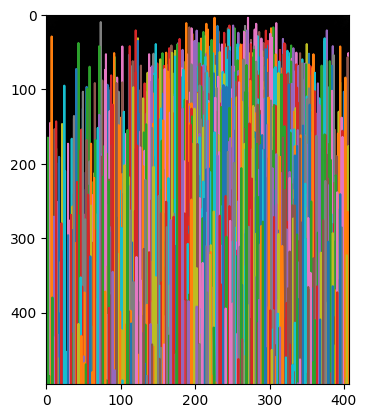

In [37]:
fft_image = np.fft.fft2(im)

plt.plot(np.abs(fft_image))
plt.imshow(np.abs(fft_image), cmap='gray', vmin=0, vmax=np.max(np.abs(fft_image)))


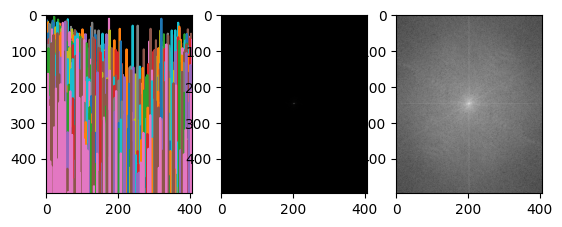

In [38]:
fft_shift = np.fft.fftshift(fft_image)  # Центрирование спектра

plt.subplot(1, 3, 1)
plt.plot(np.abs(fft_shift))
plt.imshow(np.abs(fft_shift), cmap='gray', vmin=0, vmax=np.max(np.abs(fft_image)))

plt.subplot(1, 3, 2)
plt.imshow(np.abs(fft_shift), cmap='gray', vmin=0, vmax=np.max(np.abs(fft_image)))

plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(fft_shift) + 1), cmap='gray')

## FT Transform of image is 2D Transforn in that reason is better to use 3D Plots


#### Ways to plot 3D

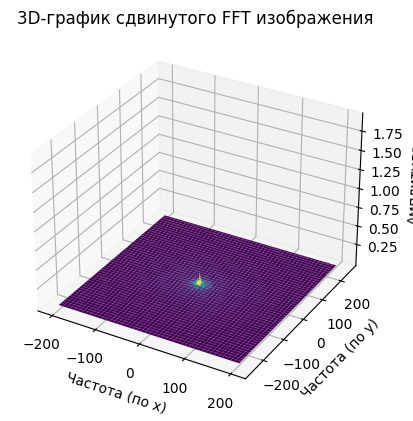

In [39]:
# Получение размеров изображения
height, width = fft_shift.shape

# Создание сетки для координат
x = np.arange(-width//2, width//2)
y = np.arange(-height//2, height//2)
X, Y = np.meshgrid(x, y)

# Построение 3D-графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.abs(fft_shift), cmap='viridis')

# Настройка осей и меток
ax.set_xlabel('Частота (по x)')
ax.set_ylabel('Частота (по y)')
ax.set_zlabel('Амплитуда')
ax.set_title('3D-график сдвинутого FFT изображения')

plt.show()

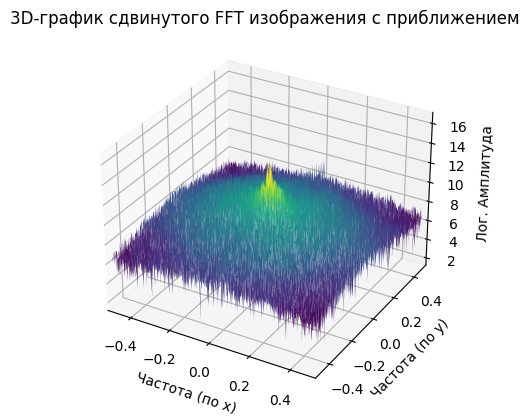

In [40]:
# Предположим, fft_shift уже вычислен и представляет собой сдвинутый Фурье-спектр изображения
height, width = fft_shift.shape

# Создание частотных массивов для осей x и y
x_freq = np.fft.fftshift(np.fft.fftfreq(width))


y_freq = np.fft.fftshift(np.fft.fftfreq(height))
#для получения частотных компонентов, которые соответствуют каждому индексу в результате Фурье-преобразования по вертикальной оси (ось y) изображения
    #np.fft.fftfreq() — это функция, которая возвращает массив частотных бинов (или "частотных ячеек") для использования в Фурье-преобразовании.
    #Эти частоты соответствуют базовым частотам, которые могут быть представлены в результате Фурье-преобразования данных определенной длины.
      #Параметр height — это количество точек в Фурье-преобразовании по вертикали,
      #то есть количество строк в изображении или, если говорить о временных рядах, количество данных в ряду.
 #Результатом вызова np.fft.fftfreq(height) является массив, который начинается с 0, возрастает до максимальной положительной частоты
 #для половины массива, а затем переходит к отрицательным частотам.
 #Частоты располагаются в порядке, который соответствует индексам результатов
 #непосредственного Фурье-преобразования, выполняемого функцией np.fft.fft2().
    #Пример: Если height = 4, результат будет [0.0, 0.25, -0.5, -0.25], что означает:
    #0.0 и 0.25 — низкие положительные частоты,
    #-0.5 и -0.25 — высокие (отрицательные здесь указывают на обратное направление частоты).


# Создание сетки для координат
X, Y = np.meshgrid(x_freq, y_freq)

# Построение 3D-графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Применение логарифмического масштаба к амплитуде для улучшения визуализации
Z = np.log(1 + np.abs(fft_shift))  # добавляем 1, чтобы избежать логарифмирования нуля

ax.plot_surface(X, Y, Z, cmap='viridis')

# Ограничение частотных осей для увеличения интересующей области
ax.set_xlim(-0.50, 0.50)  # Ограничиваем частоты по оси X
ax.set_ylim(-0.50, 0.50)  # Ограничиваем частоты по оси Y

# Настройка осей и меток
ax.set_xlabel('Частота (по x)')
ax.set_ylabel('Частота (по y)')
ax.set_zlabel('Лог. Амплитуда')
ax.set_title('3D-график сдвинутого FFT изображения с приближением')

plt.show()

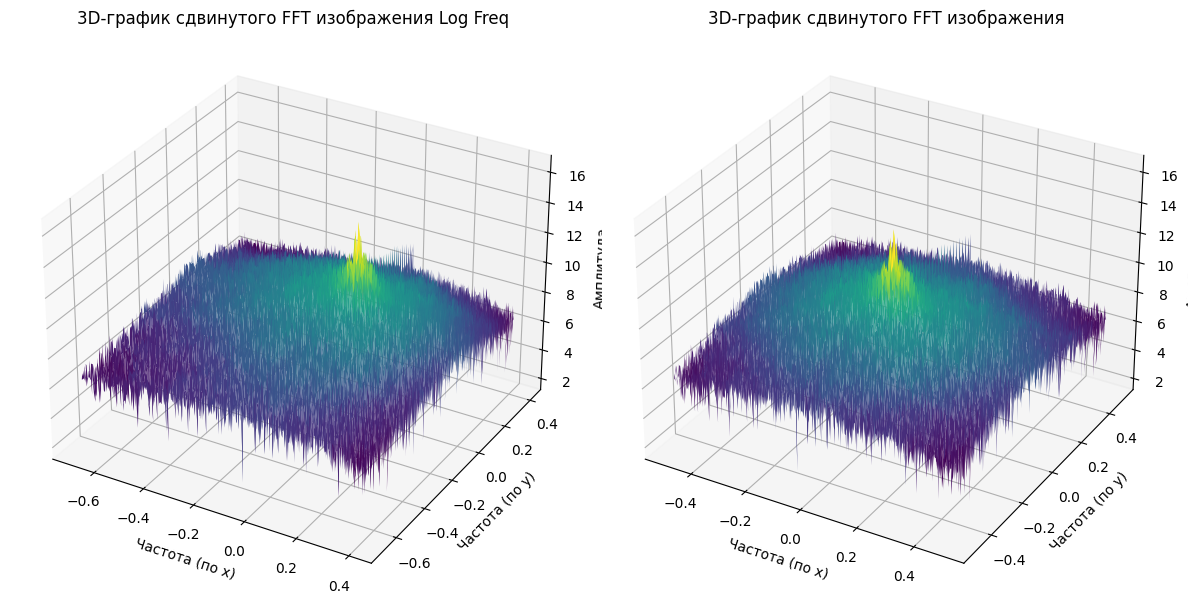

In [41]:
ZX = np.log(1 + np.abs(fft_shift))
height, width = ZX.shape

# Создание частотных массивов для осей x и y
x_freq = np.log(np.fft.fftshift(np.fft.fftfreq(width))+1)
y_freq = np.log(np.fft.fftshift(np.fft.fftfreq(height))+1)

# Создание сетки для координат
X, Y = np.meshgrid(x_freq, y_freq)

# Создание частотных массивов для осей x и y
xnl_freq = np.fft.fftshift(np.fft.fftfreq(width))
ynl_freq = np.fft.fftshift(np.fft.fftfreq(height))

# Создание сетки для координат
Xnl, Ynl = np.meshgrid(xnl_freq, ynl_freq)

# Создание 3D-графиков
fig = plt.figure(figsize=(12, 6))

# Построение 3D-графика с логифмированим частот
ax1 = fig.add_subplot(121, projection='3d')
#ax1.plot_surface(X, Y, np.abs(ZX), cmap='viridis')
ax1.plot_surface(X, Y, ZX, cmap='viridis')

# Настройка осей и меток
ax1.set_xlabel('Частота (по x)')
ax1.set_ylabel('Частота (по y)')
ax1.set_zlabel('Амплитуда')
ax1.set_title('3D-график сдвинутого FFT изображения Log Freq')


# Построение 3D-графика 2
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(Xnl, Ynl, np.abs(ZX), cmap='viridis')

# Настройка осей и меток
ax2.set_xlabel('Частота (по x)')
ax2.set_ylabel('Частота (по y)')
ax2.set_zlabel('Амплитуда')
ax2.set_title('3D-график сдвинутого FFT изображения')

plt.tight_layout()  # Для автоматического размещения графиков с учетом места
plt.show()

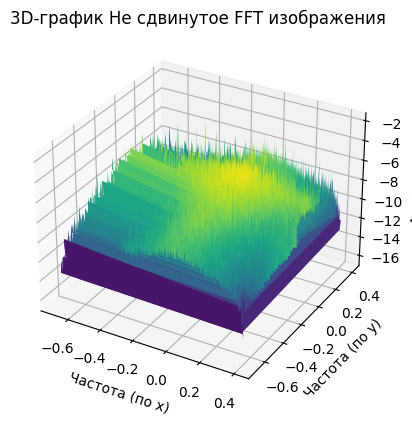

In [42]:
ZXY = np.log(1 + np.abs(fft_image))
height, width = ZXY.shape

# Создание частотных массивов для осей x и y
x_freq = np.log(np.fft.fftfreq(width)+1)
y_freq = np.log(np.fft.fftfreq(height)+1)

# Создание сетки для координат
X, Y = np.meshgrid(x_freq, y_freq)

# Построение 3D-графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X, Y, np.abs(ZX), cmap='viridis')
ax.plot_surface(X, Y, -Z, cmap='viridis')

# Настройка осей и меток
ax.set_xlabel('Частота (по x)')
ax.set_ylabel('Частота (по y)')
ax.set_zlabel('Амплитуда')
ax.set_title('3D-график Не сдвинутое FFT изображения')

plt.show()

#### B -  display a boxplot with the magnitude values

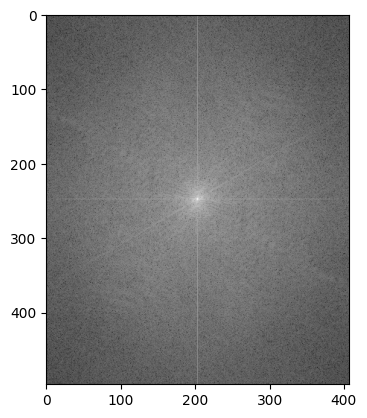

In [43]:
# Вычисление амплитудного спектра
magnitude_spectrum = np.abs(fft_shift)
plt.imshow(np.log(1+magnitude_spectrum))

#### A - compute the lowest and highest magnitude

In [44]:
# Нахождение наименьшей и наибольшей амплитуды
lowest_magnitude = np.min(magnitude_spectrum)
highest_magnitude = np.max(magnitude_spectrum)
print("Lowerst", lowest_magnitude)
print("Highest", highest_magnitude)

Lowerst 3.643551055750835
Highest 19406067.0


#### C - plot an histogram of the phase values

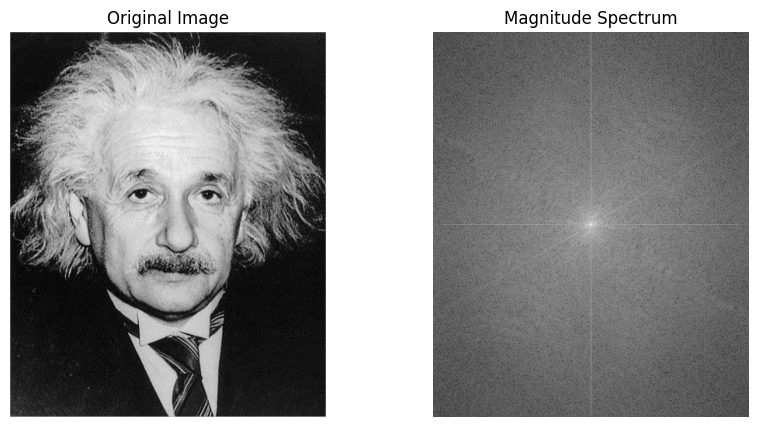

Lowerst 3.643551055750835
Highest 19406067.0


In [45]:
#Visualization of the original image and its spectrum
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(np.log(1 + magnitude_spectrum), cmap='gray') # Logarithmic scaling for clarity
ax[1].set_title('Magnitude Spectrum')
ax[1].axis('off')


plt.show()

print("Lowerst", lowest_magnitude)
print("Highest", highest_magnitude)

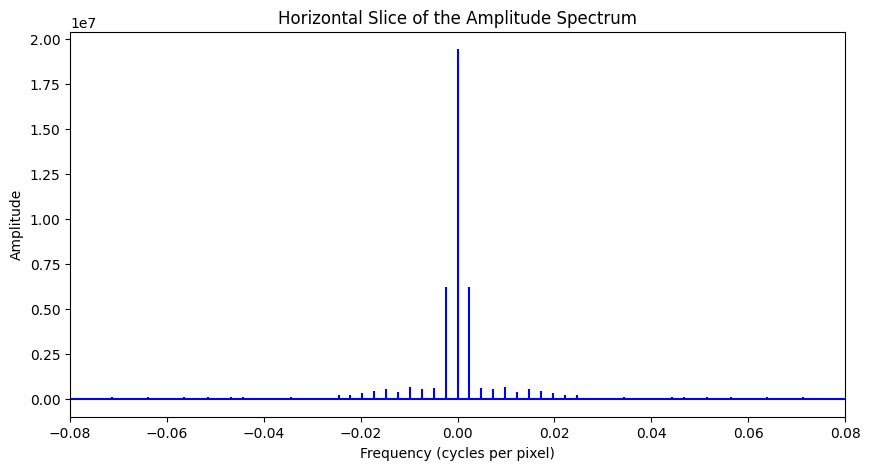

In [46]:
# Выбор центральной строки спектра (горизонтальный срез)
central_row = magnitude_spectrum[magnitude_spectrum.shape[0] // 2]

# Создание массива частот для горизонтальной оси
frequencies = np.fft.fftshift(np.fft.fftfreq(im.shape[1]))

# Построение графика
plt.figure(figsize=(10, 5))
plt.stem(frequencies, central_row, 'b', markerfmt=" ", basefmt="-b")
plt.title('Horizontal Slice of the Amplitude Spectrum')
plt.xlabel('Frequency (cycles per pixel)')
plt.ylabel('Amplitude')
plt.xlim(-0.08, 0.08)  # Ограничение диапазона частот для наглядности
plt.show()

# Ex Question 2 convolution theorem applied to the mean  filter

Теорема свертки утверждает, что свертка двух функций в пространственной области эквивалентна их умножению в частотной области.

Размер фильтра и его частотная характеристика: Чем больше размер фильтра среднего, тем меньше частотные компоненты сохраняются после его применения. Это происходит из-за того, что больший размер фильтра приводит к более сильному размытию и более широкому диапазону частот, который подавляется фильтром. В преобразовании Фурье это отражается в ширине главного лепестка, который соответствует основной частоте фильтра.

Импульсный отклик и размер фильтра: Размер фильтра среднего также связан с его импульсным откликом, который представляет собой форму ядра фильтра в пространственной области. Чем больше размер фильтра, тем более плавным становится его импульсный отклик. В преобразовании Фурье это проявляется в форме спектра фильтра, который может быть более широким и плавным при большем размере фильтра.

Сдвиг и усечение в преобразовании Фурье: Больший размер фильтра среднего также может привести к более выраженному сдвигу преобразования Фурье. Поскольку фильтр среднего усекает высокие частоты, его преобразование Фурье может быть сдвинуто в сторону более низких частот.

Итак, в общем, размер фильтра среднего имеет прямое влияние на его преобразование Фурье, определяя ширину главного лепестка и форму спектра, что в конечном итоге влияет на способность фильтра к подавлению различных частотных компонент изображения.

In [28]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [48]:
# Параметры Гауссова фильтра
sigma = 3  # Стандартное отклонение Гауссова фильтра

## Var`s to create Gausse

In [79]:
# Создание Гауссова фильтра 1D
size = 6*sigma  # Размер фильтра: +/- 3 стандартных отклонения
x = np.linspace(-size//2, size//2, size)
gaussV1 = np.exp(-x**2/(2*sigma**2))
gaussV1 /= gaussV1.sum()  # Нормировка фильтра
gaussV1

array([0.00156639, 0.00424318, 0.01014808, 0.0214278 , 0.03994591,
       0.06574583, 0.09553558, 0.12256404, 0.1388232 , 0.1388232 ,
       0.12256404, 0.09553558, 0.06574583, 0.03994591, 0.0214278 ,
       0.01014808, 0.00424318, 0.00156639])

In [80]:
# Создание 2D массива для обоих измерений Ver 1
sigma = 3  # Стандартное отклонение Гауссова фильтра
size = int(6 * sigma)  # Размер фильтра: +/- 3 стандартных отклонения
x = np.linspace(-size // 2, size // 2, size)
y = np.linspace(-size // 2, size // 2, size)
X, Y = np.meshgrid(x, y)
gaussV2 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
gaussV2 /= gaussV2.sum()
gaussV2

array([[2.45357014e-06, 6.64645717e-06, 1.58958215e-05, 3.35642368e-05,
        6.25707859e-05, 1.02983459e-04, 1.49645746e-04, 1.91982795e-04,
        2.17450933e-04, 2.17450933e-04, 1.91982795e-04, 1.49645746e-04,
        1.02983459e-04, 6.25707859e-05, 3.35642368e-05, 1.58958215e-05,
        6.64645717e-06, 2.45357014e-06],
       [6.64645717e-06, 1.80045364e-05, 4.30600678e-05, 9.09219014e-05,
        1.69497518e-04, 2.78971096e-04, 4.05374204e-04, 5.20060707e-04,
        5.89051150e-04, 5.89051150e-04, 5.20060707e-04, 4.05374204e-04,
        2.78971096e-04, 1.69497518e-04, 9.09219014e-05, 4.30600678e-05,
        1.80045364e-05, 6.64645717e-06],
       [1.58958215e-05, 4.30600678e-05, 1.02983459e-04, 2.17450933e-04,
        4.05374204e-04, 6.67193759e-04, 9.69502370e-04, 1.24378928e-03,
        1.40878842e-03, 1.40878842e-03, 1.24378928e-03, 9.69502370e-04,
        6.67193759e-04, 4.05374204e-04, 2.17450933e-04, 1.02983459e-04,
        4.30600678e-05, 1.58958215e-05],
       [3.356

In [81]:
# Создание 2D массива для обоих измерений
gaussV1_2d = np.outer(gaussV1, gaussV1.T)
gauss_2d /= gauss_2d.sum()
gauss_2d
#print(gauss_2d)

array([[6.02000644e-12, 1.63075489e-11, 3.90015130e-11, ...,
        3.90015130e-11, 1.63075489e-11, 6.02000644e-12],
       [1.63075489e-11, 4.41753930e-11, 1.05650897e-10, ...,
        1.05650897e-10, 4.41753930e-11, 1.63075489e-11],
       [3.90015130e-11, 1.05650897e-10, 2.52677141e-10, ...,
        2.52677141e-10, 1.05650897e-10, 3.90015130e-11],
       ...,
       [3.90015130e-11, 1.05650897e-10, 2.52677141e-10, ...,
        2.52677141e-10, 1.05650897e-10, 3.90015130e-11],
       [1.63075489e-11, 4.41753930e-11, 1.05650897e-10, ...,
        1.05650897e-10, 4.41753930e-11, 1.63075489e-11],
       [6.02000644e-12, 1.63075489e-11, 3.90015130e-11, ...,
        3.90015130e-11, 1.63075489e-11, 6.02000644e-12]])

In [52]:
#Еще вариант самый протой :)))
# Создание гауссова фильтра
sigma = 3
kernel_size = 6*sigma
gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
gaussian_filter = np.outer(gaussian_kernel, gaussian_kernel.T)
gaussian_filter


array([[5.75721425e-06, 1.40039945e-05, 3.04815136e-05, 5.93698816e-05,
        1.03476301e-04, 1.61384070e-04, 2.25229614e-04, 2.81277748e-04,
        3.18729445e-04, 3.18729445e-04, 2.81277748e-04, 2.25229614e-04,
        1.61384070e-04, 1.03476301e-04, 5.93698816e-05, 3.04815136e-05,
        1.40039945e-05, 5.75721425e-06],
       [1.40039945e-05, 3.40636727e-05, 7.41440095e-05, 1.44412811e-04,
        2.51698388e-04, 3.92554721e-04, 5.47854246e-04, 6.84187155e-04,
        7.75285616e-04, 7.75285616e-04, 6.84187155e-04, 5.47854246e-04,
        3.92554721e-04, 2.51698388e-04, 1.44412811e-04, 7.41440095e-05,
        3.40636727e-05, 1.40039945e-05],
       [3.04815136e-05, 7.41440095e-05, 1.61384070e-04, 3.14333247e-04,
        5.47854246e-04, 8.54446355e-04, 1.19247595e-03, 1.48922224e-03,
        1.68750988e-03, 1.68750988e-03, 1.48922224e-03, 1.19247595e-03,
        8.54446355e-04, 5.47854246e-04, 3.14333247e-04, 1.61384070e-04,
        7.41440095e-05, 3.04815136e-05],
       [5.936

## Aplay spatial domain Gaussse

In [88]:
gaussian_filter = gaussV2

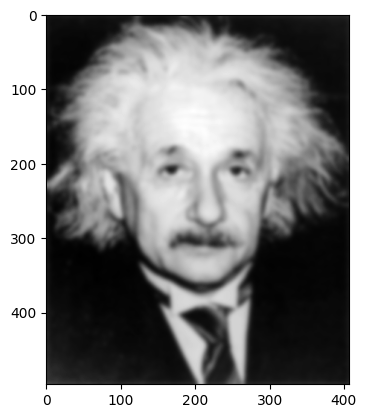

In [89]:
# Применение Гауссова фильтра через свертку
# Применение фильтра
filtered_img = cv2.filter2D(im, -1, gaussian_filter)
plt.imshow(filtered_img)

## Aplay freq domain Gaussse

In [90]:
img = im


In [91]:
# Вычисление преобразования Фурье изображения и фильтра
f_img = np.fft.fft2(img)
f_gaussian_filter = np.fft.fft2(gaussian_filter, s=img.shape)

In [92]:
f_img_filtered = f_img * f_gaussian_filter

In [93]:
# Обратное преобразование Фурье для получения отфильтрованного изображения
filtered_img_fft = np.fft.ifft2(f_img_filtered).real

## Plot to compare

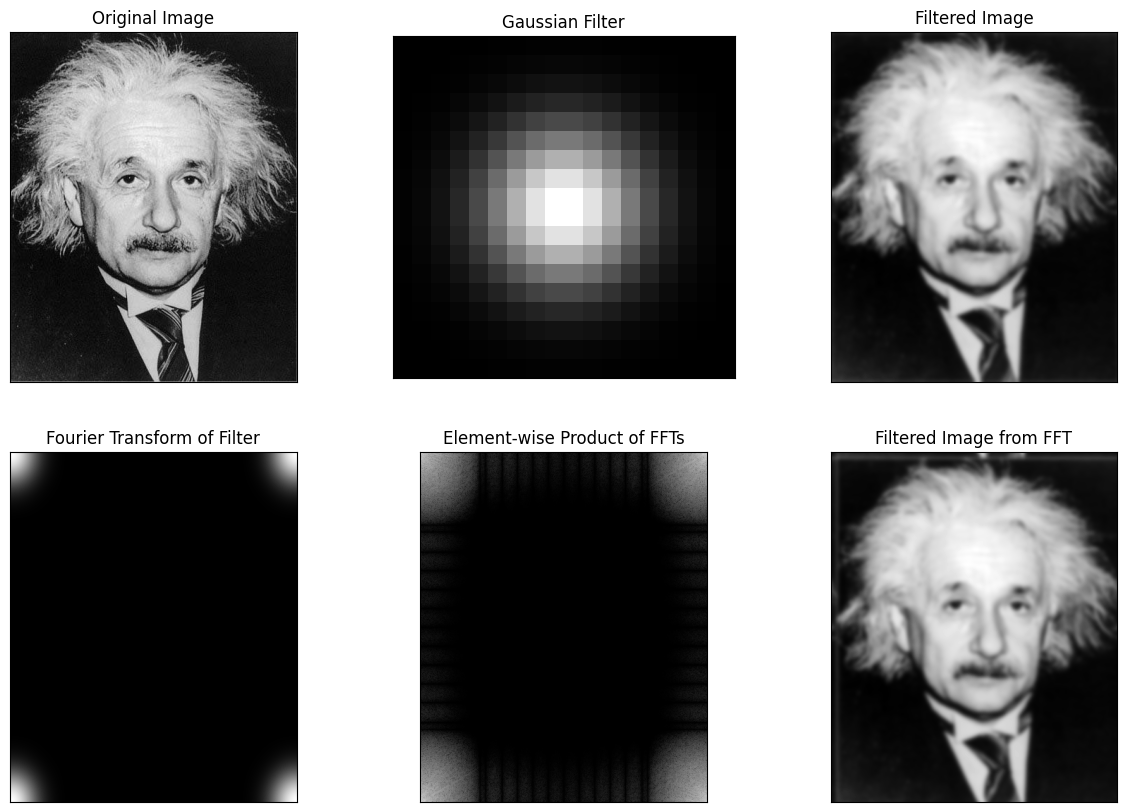

In [94]:
# Увеличение размера изображений
plt.figure(figsize=(15, 10))

# Отображение результатов
plt.subplot(2, 3, 1), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 3, 2), plt.imshow(gaussian_filter, cmap='gray')
plt.title('Gaussian Filter'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 3, 3), plt.imshow(filtered_img, cmap='gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 3, 4), plt.imshow(np.log(1 + np.abs(f_gaussian_filter)), cmap='gray')
plt.title('Fourier Transform of Filter'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 3, 5), plt.imshow(np.log(1 + np.abs(f_img_filtered)), cmap='gray')
plt.title('Element-wise Product of FFTs'), plt.xticks([]), plt.yticks([])
plt.subplot(2, 3, 6), plt.imshow(filtered_img_fft, cmap='gray')
plt.title('Filtered Image from FFT'), plt.xticks([]), plt.yticks([])
plt.show()

# Ex Question 3 A practical implication of the convolution theorem is the computational saving

### Def functions

In [98]:
filename = "einstein.jpg"
path_input = os.path.join(folder_path, filename)
test_image = Image.open(path_input)

### resize_image

In [96]:
def resize_image(input_image, scale_factor):
    # Определяем новые размеры
    new_width = int(input_image.width * scale_factor)
    new_height = int(input_image.height * scale_factor)

    # Изменяем размер изображения
    resized_image = input_image.resize((new_width, new_height), Image.ANTIALIAS)

    return resized_image

<ipython-input-96-6d5836c14103>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = input_image.resize((new_width, new_height), Image.ANTIALIAS)


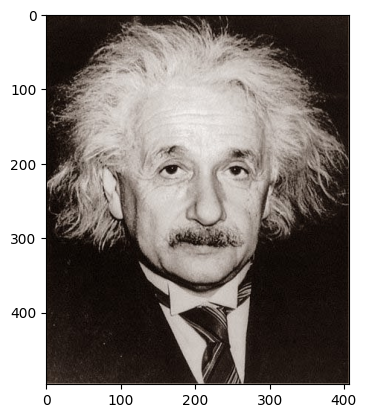

In [118]:
# Tested Out
output_image = resize_image(test_image, 1)
plt.imshow(output_image)


### def Gausin fft

In [30]:
# OLd convert
im = np.array(test_image.convert('L'))

In [120]:
# Will use std from CV2
def create_gaussian_filter(sigma):
    kernel_size = int(6 * sigma)  # kernel_size должен быть нечетным
    gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
    gaussian_filter = np.outer(gaussian_kernel, gaussian_kernel.T)
    return gaussian_filter

In [121]:
# Warp FFT Gausse code in def
def apply_gaussian_fft(img, sigma):

    gaussian_filter = create_gaussian_filter(sigma)

    # Вычисление преобразования Фурье изображения и фильтра
    f_img = np.fft.fft2(img)
    f_gaussian_filter = np.fft.fft2(gaussian_filter, s=img.shape)
    f_img_filtered = f_img * f_gaussian_filter
    # Обратное преобразование Фурье для получения отфильтрованного изображения
    filtered_img_fft = np.fft.ifft2(f_img_filtered).real

    return filtered_img_fft

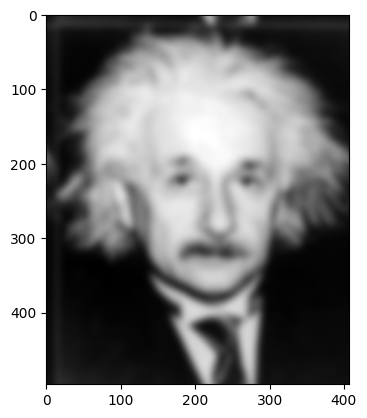

In [125]:
zxv = apply_gaussian_fft(im, 5)
plt.imshow(zxv, cmap='gray')

### Def GausinVector

In [132]:
def GausinVector(sigma):
    n = sigma*6+1
# Генерируем одномерный Гауссов массив
    GV =  cv2.getGaussianKernel(n, sigma).reshape(-1, 1)

    return GV

In [133]:
v = GausinVector(3)
v

array([[0.00147945],
       [0.00380424],
       [0.00875346],
       [0.01802341],
       [0.03320773],
       [0.05475029],
       [0.08077532],
       [0.106639  ],
       [0.12597909],
       [0.133176  ],
       [0.12597909],
       [0.106639  ],
       [0.08077532],
       [0.05475029],
       [0.03320773],
       [0.01802341],
       [0.00875346],
       [0.00380424],
       [0.00147945]])

In [146]:
# Will use our old GausseVector Function to compare
import numpy as np
from scipy.signal import convolve2d


def GausinVector(sigma):
    n = sigma*6+1
# Генерируем одномерный Гауссов массив
    GV =  cv2.getGaussianKernel(n, sigma).reshape(-1, 1)

    return GV

def GausinVectorFilter(image, sigma):

    normalized_array = GausinVector(sigma)

    result_vert = convolve2d(image, normalized_array, mode='same', boundary='symm')
    #result_horiz = result_horiz.astype(np.uint8)

    horiz_normalized_array = normalized_array.T

    result_total = convolve2d(result_vert, horiz_normalized_array, mode='same', boundary='symm')
    #result_total = result_total.astype(np.uint8)

    #plt.imshow(result_total, cmap='gray')

    return result_total

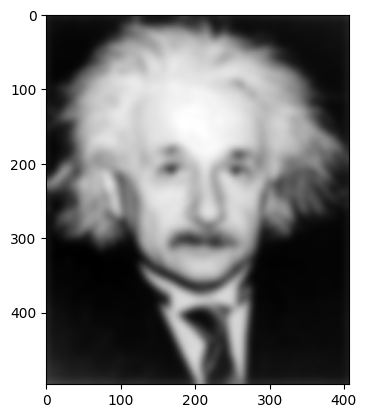

In [136]:
zxc = GausinVectorFilter(im, 5)
plt.imshow(zxc, cmap='gray')

### Def measure_performance

In [152]:
def measure_performance(img_original, sigma, max_scale):

    times_fft = []
    times_conv = []
    scale_factors = np.linspace(1, max_scale, num=max_scale)  # Create scale factors from 1 to max_scale

    for scale in scale_factors:
        img_resized = resize_image(img_original, scale)
        im = np.array(img_resized.convert('L'))

        start_time = time()
        apply_gaussian_fft(im, sigma)
        times_fft.append(time() - start_time)

        start_time = time()
        GausinVectorFilter(im, sigma)
        times_conv.append(time() - start_time)

    plt.figure(figsize=(10, 5))
    plt.plot(scale_factors, times_fft, label='FFT-based Gaussian Filter')
    plt.plot(scale_factors, times_conv, label='Vector-based Gaussian Filter')
    plt.xlabel('Scale Factor')
    plt.ylabel('Time (seconds)')
    plt.title(f'Performance Comparison: {sigma} Sigma')
    plt.legend()
    plt.grid(True)
    plt.show()

### Tests

In [29]:
import numpy as np
import cv2
from time import time
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from PIL import Image

<ipython-input-96-6d5836c14103>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = input_image.resize((new_width, new_height), Image.ANTIALIAS)


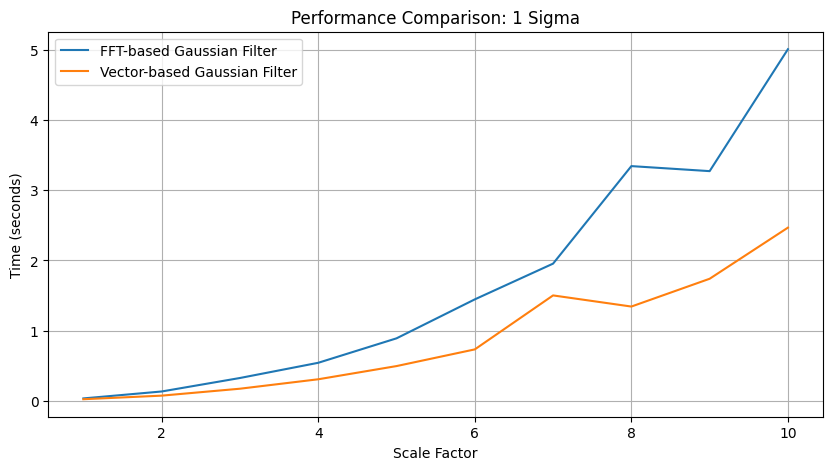

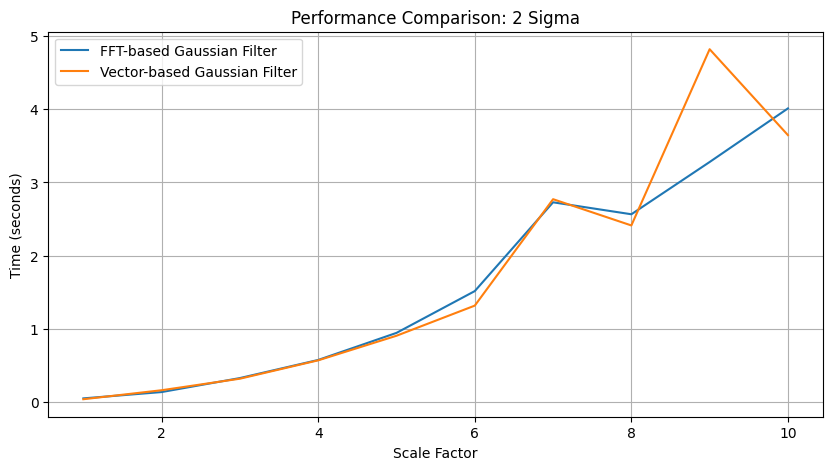

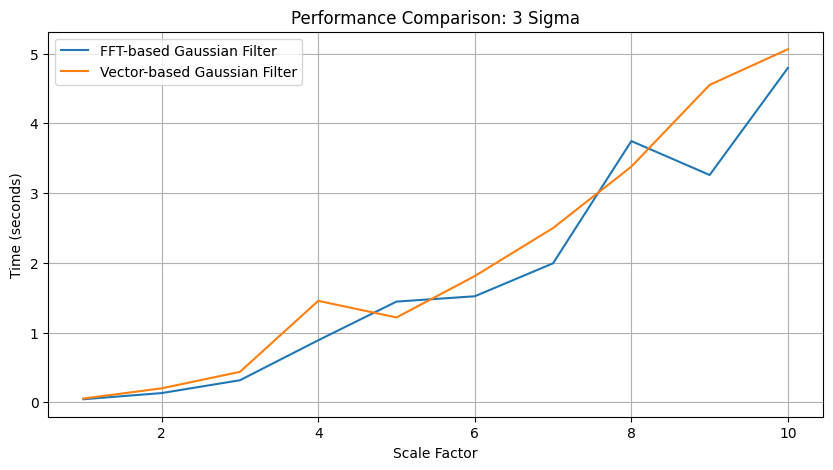

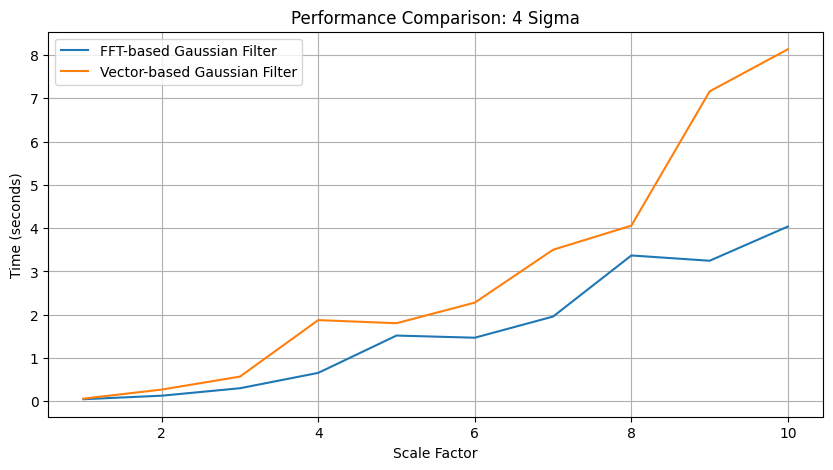

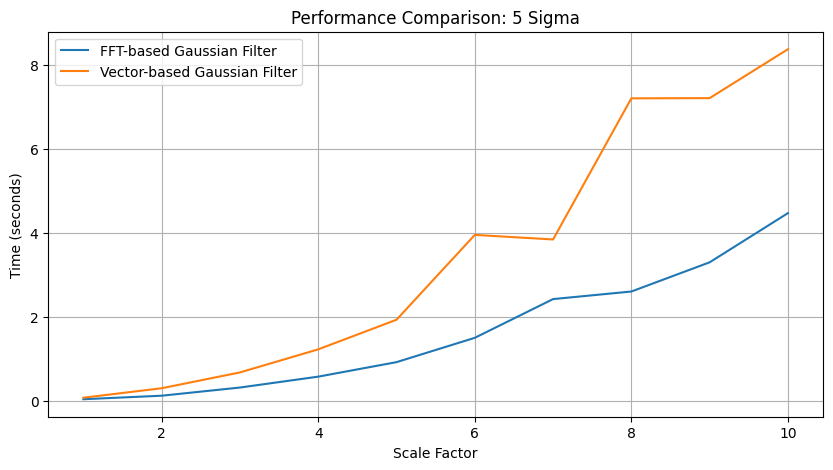

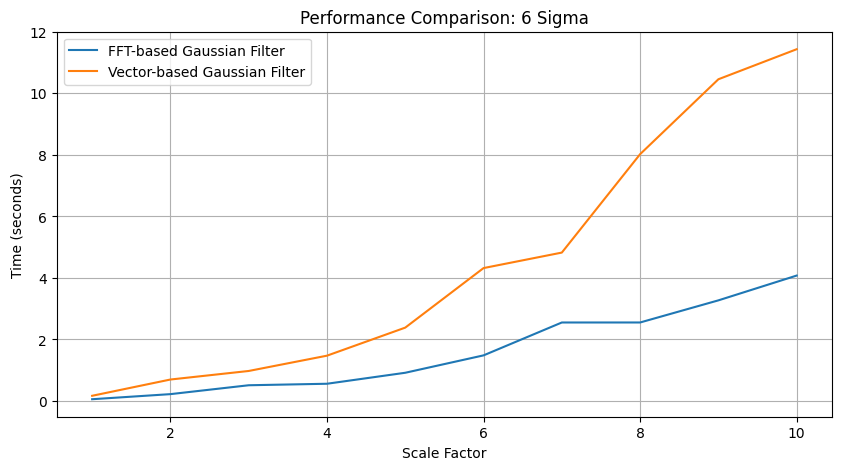

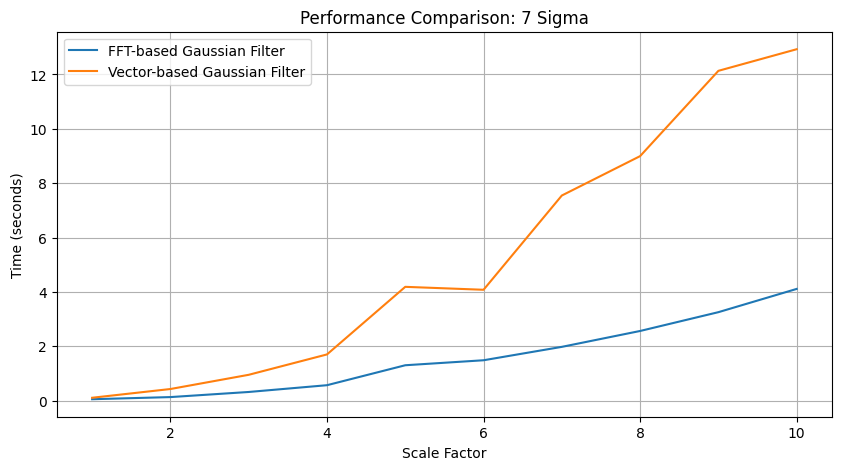

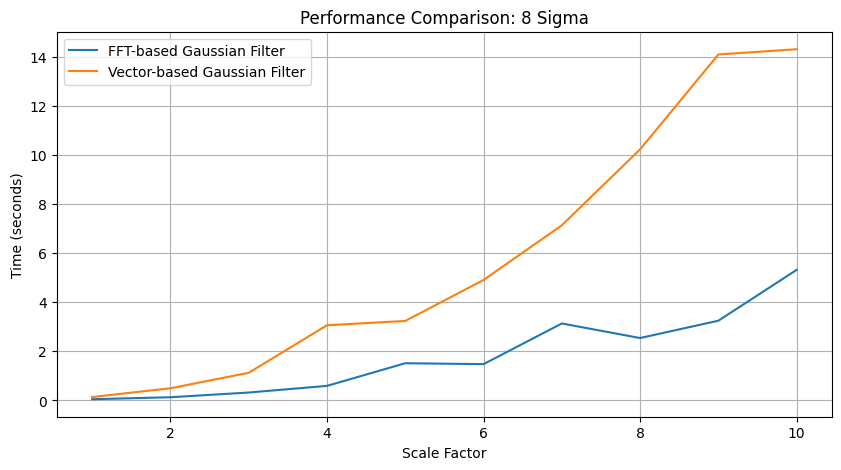

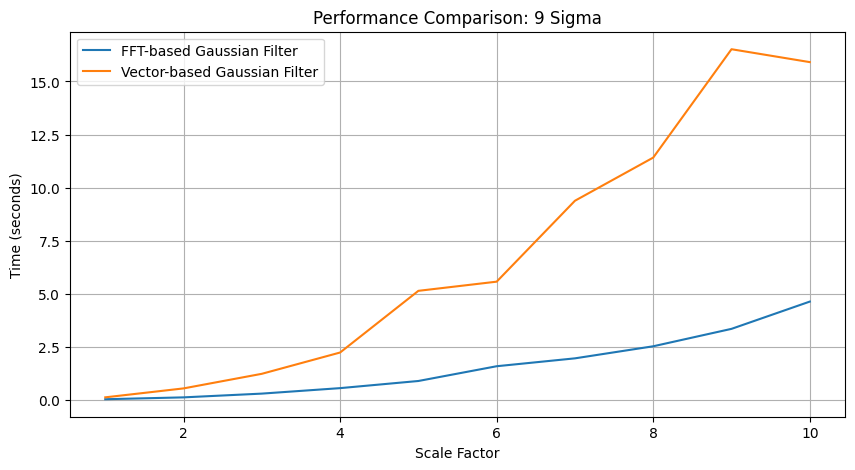

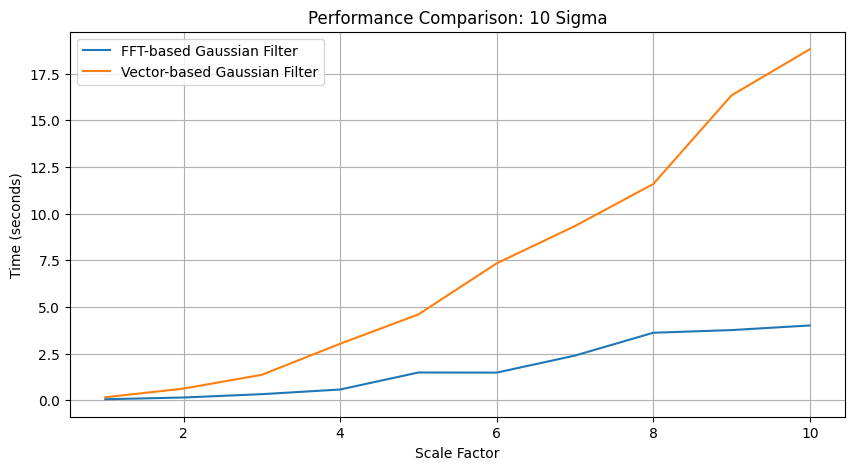

In [153]:

# Usage
#sigma = 6  # Standard deviation for the Gaussian kernel
max_scale = 10  # Maximum scale factor

for sigma in range(1, 11):  # Sigma from 1 to 10
    measure_performance(test_image, sigma, max_scale)

# Ex Question 4 Write my_mask  write my_filter(im,n)

##Write my_mask

In [38]:
# 1- создаем массив нулей размером n×n с помощью np.zeros((n, n))

# 2 - используем функцию np.tril(np.ones((n, n)), k=-1), чтобы создать треугольную матрицу,
#     где все элементы ниже главной диагонали равны единице, а все остальные элементы равны нулю
#       -np.ones((n, n)), чтобы создать матрицу единиц
#        -а затем np.tril() используется для сохранения только нижней треугольной части.
#         -np.tril() возвращает нижнюю (или нижнюю левую) треугольную часть массива, включая главную диагональ.
#            -Параметр
               #k=-1 указывает, что мы хотим сохранить только элементы ниже главной диагонали.
               #k=0, то была бы возвращена нижняя треугольная часть, включая главную диагональ,
               #k=1 возвращалась бы нижняя треугольная часть и первый наддиагональный ряд
#          - np.triu()
              #k определяет количество диагоналей, которые нужно сохранить выше главной.
              #k=0, будут сохранены только элементы на главной диагонали.
              #Если k=1, будут сохранены элементы над главной диагональю и первый наддиагональный ряд.

#          -Мы умножаем эту треугольную матрицу на -1, чтобы получить матрицу с отрицательными значениями в нижнем треугольнике.

#3 - Затем мы добавляем диагональную матрицу с единицами с помощью np.eye(n), чтобы получить диагональ со значениями 0.

#4 - Результаты складываются, и в итоге мы получаем желаемую маску, как указано в задании.

### Tests perts of code

In [39]:
n = 5
mask = np.zeros((n, n))
mask

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [40]:
n = 5
mask_o = np.ones((n, n))
mask_o

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [41]:
fg = np.triu(mask_o, k=1) * -1
fg

array([[-0., -1., -1., -1., -1.],
       [-0., -0., -1., -1., -1.],
       [-0., -0., -0., -1., -1.],
       [-0., -0., -0., -0., -1.],
       [-0., -0., -0., -0., -0.]])

In [42]:
df = np.tril(mask_o, k=-1)
df

array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.]])

In [43]:
mask = fg + df
mask

array([[ 0., -1., -1., -1., -1.],
       [ 1.,  0., -1., -1., -1.],
       [ 1.,  1.,  0., -1., -1.],
       [ 1.,  1.,  1.,  0., -1.],
       [ 1.,  1.,  1.,  1.,  0.]])

In [44]:
#Better way
n = 5
mask = np.zeros((n, n))
#np.fill_diagonal(mask, 1)  # This fills the diagonal with 1 if needed, otherwise remove it if you need 0
mask[np.triu_indices(n, 1)] = -1 #triu для верхней  k=1 и k=-1 указывают на смещение относительно диагонали (исключая диагональ).
mask[np.tril_indices(n, -1)] = 1 #tril для нижней
mask

array([[ 0., -1., -1., -1., -1.],
       [ 1.,  0., -1., -1., -1.],
       [ 1.,  1.,  0., -1., -1.],
       [ 1.,  1.,  1.,  0., -1.],
       [ 1.,  1.,  1.,  1.,  0.]])

### Def my_mask(n)

In [45]:
def my_mask(n):
    """
    Создает маску размером n x n, где верхняя треугольная часть матрицы (не включая диагональ)
    заполнена -1, а нижняя треугольная часть (не включая диагональ) заполнена 1.

    Параметры:
        n (int): Размерность матрицы (количество строк и столбцов).

    Возвращает:
        np.ndarray: Матрица размером n x n с заданными значениями в верхней и нижней треугольниках.
    """
    mask = np.zeros((n, n), dtype=int)  # Инициализация матрицы нулями
    np.fill_diagonal(mask, 0)  # Опционально, если нужно явно указать, что диагональ должна быть нулевой
    mask[np.triu_indices(n, 1)] = -1  # Заполнение верхнего треугольника (без диагонали)
    mask[np.tril_indices(n, -1)] = 1  # Заполнение нижнего треугольника (без диагонали)
    return mask

### Def my_filter(im,n)

In [46]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift

def my_filter(im, n):
    """
    Applies a triangular mask filter to an image in the frequency domain.

    Parameters:
        im (np.ndarray): The input image to be filtered.
        n (int): The size of the mask. The mask is created by `my_mask(n)` and then applied to the image.

    Returns:
        np.ndarray: The filtered image.
    """
    # Generate the mask
    mask = my_mask(n)

    # Calculate padding sizes to match the image dimensions
    pad_height_top = (im.shape[0] - n) // 2
    pad_height_bottom = im.shape[0] - n - pad_height_top
    pad_width_left = (im.shape[1] - n) // 2
    pad_width_right = im.shape[1] - n - pad_width_left


    #numpy.pad(array, pad_width, mode='constant', **kwargs)
      #pad_width: указывает толщину паддинга для каждой оси может быть числом,
      #кортежем чисел или кортежем кортежей, который задает отступы для каждой из осей.
      #mode: способ заполнения паддинга. Он может принимать различные значения,
      #такие как 'constant', 'edge', 'linear_ramp', 'maximum', 'mean', 'median', 'minimum',
      #'reflect', 'symmetric', 'wrap' и другие.
        #'constant' — заполняет паддинг константными значениями (которые могут быть заданы с помощью constant_values).
        #'edge' — заполняет паддинг значениями на краях массива.
        #'reflect' — отражает массив в паддинге.
        #'symmetric' — отражает и инвертирует массив в паддинге.
        #'wrap' — оборачивает массив вокруг к оппозитному краю.
        #kwargs: ключевые аргументы специфичные для выбранного режима, например
        #constant_values для mode='constant', которые указывают значение для заполнения паддингов.


    padded_mask = np.pad(mask,
                         ((pad_height_top, pad_height_bottom),
                          (pad_width_left, pad_width_right)),
                         'constant', constant_values=0)

    # Shift the mask to center it
    padded_mask = fftshift(padded_mask)

    # Apply the mask in the frequency domain
    f_im = fft2(im)
    f_masked_im = f_im * padded_mask
    filtered_im = ifft2(f_masked_im).real

    return filtered_im

### Aplay my_filter(im,n)

array([[125,  82,  83, ...,  99,  91, 147],
       [ 83,  36,  31, ...,  38,  31,  88],
       [ 85,  34,  25, ...,  36,  30,  87],
       ...,
       [ 97,  56,  82, ...,  20,  31,  89],
       [102,  62,  71, ...,  19,  30,  88],
       [157, 130, 137, ..., 131, 132, 147]], dtype=uint8)
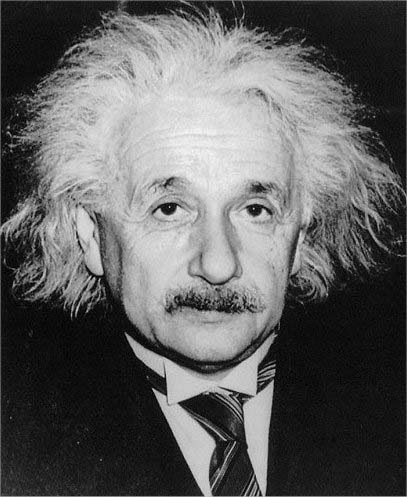

In [47]:
im

In [48]:
filtered_image = my_filter(im, 4)

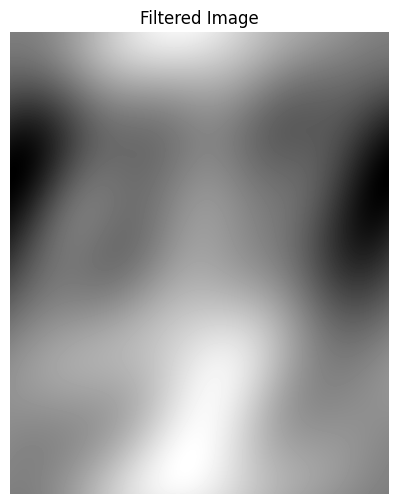

In [49]:
import matplotlib.pyplot as plt

# Предположим, что `filtered_image` это ваше изображение в виде массива NumPy
plt.figure(figsize=(6,6))  # Устанавливаем размер фигуры
plt.imshow(filtered_image, cmap='gray')  # `cmap='gray'` указывает на то, что это градации серого
plt.title("Filtered Image")
plt.axis('off')  # Отключить отображение осей
plt.show()

# Ex Question 5 Get the Fourier transform of stp1.gif and stp2.gif.

Вычислите и наблюдайте обратное преобразование их комбинации λ · F1 + (1 − λ) · F2, где λ ∈ [0,1]. Какое свойство преобразования Фурье (FT) иллюстрирует этот результат?

Линейная Комбинация FT: Вычисление λ · F1 + (1 − λ) · F2 представляет собой линейную комбинацию двух Фурье-образов, где λ — параметр, изменяющийся от 0 до 1. Это позволяет "смешивать" изображения в частотной области.

Обратное Преобразование Фурье: После применения линейной комбинации, вычисление обратного преобразования Фурье покажет, как смешанное частотное представление преобразуется обратно в пространственное домен (т.е., в изображение).

Иллюстрация Свойства Преобразования Фурье:

Линейность: Основное свойство, демонстрируемое здесь — это линейность преобразования Фурье. FT линейно, что означает, что преобразование Фурье линейной комбинации функций равно той же линейной комбинации преобразований этих функций.
Смешивание Частот: Этот эксперимент также показывает, как частотные компоненты двух разных изображений могут быть смешаны для создания новых изображений.

## Load Images

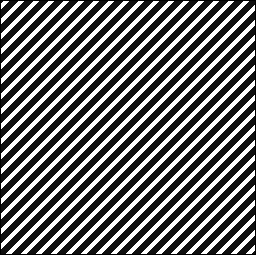

In [50]:
filename = "stp1.gif"
path_input_im1 = os.path.join(folder_path, filename)
im1 = Image.open(path_input_im1)
im1


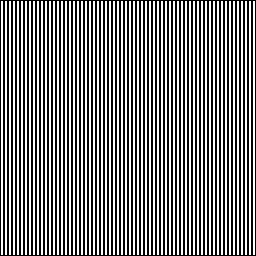

In [51]:
filename = "stp2.gif"
path_input_im2 = os.path.join(folder_path, filename)
im2 = Image.open(path_input_im2)
im2


In [52]:
im1np = np.array(im1.convert('L'))
im2np = np.array(im2.convert('L'))

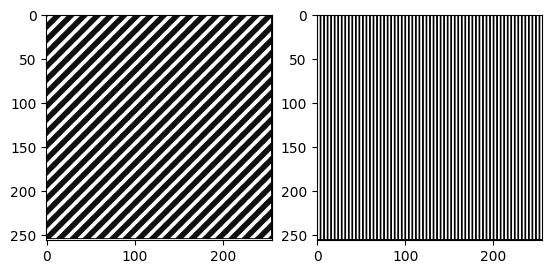

In [53]:
fig, ax = plt.subplots(1, 2)  # создаем фигуру с двумя подграфиками
ax[0].imshow(im1np)
ax[1].imshow(im2np)

## Load Lib`s

In [69]:
import numpy as np
import imageio.v2 as imageio
from imageio import imread
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift

## Exe

In [70]:
#Faster and better imread из библиотеки imageio, которая предназначена для чтения изображений в массивы NumPy.
im1np = imageio.imread(path_input_im1, pilmode='L')
im2np = imageio.imread(path_input_im2, pilmode='L')

In [71]:
# Преобразование Фурье
F1 = fft2(im1np)
F2 = fft2(im2np)

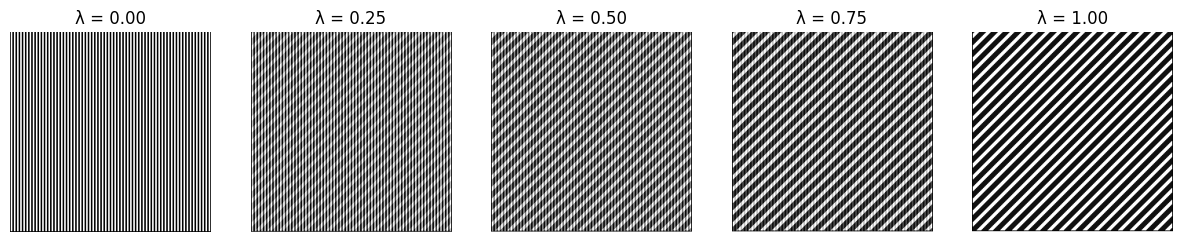

In [74]:
# Линейная комбинация и обратное преобразование
lambdas = np.linspace(0, 1, num=5)  # Несколько значений λ для демонстрации

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, lam in enumerate(lambdas):
    combined_F = lam * F1 + (1 - lam) * F2
    result_image = ifft2(combined_F).real  # Обратное преобразование для получения изображения
                                           #.real просто удаляет мнимую часть, оставляя только вещественную.


    axs[i].imshow(result_image, cmap='gray')
    axs[i].set_title(f'λ = {lam:.2f}')
    axs[i].axis('off')

plt.show()

# Ex Question 6 FT is distributive - Answe No

 выполняется ли равенство F(I1 * I2) = F(I1) * F(I2)

Однако, важно отметить, что это утверждение неверно для преобразования Фурье. Преобразование Фурье действительно дистрибутивно по отношению к сумме (линейное), но не по отношению к умножению. Вместо этого, преобразование Фурье произведения двух функций соответствует свертке их Фурье-образов (и наоборот)

In [ ]:
import numpy as np
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from imageio import imread

## Load Images

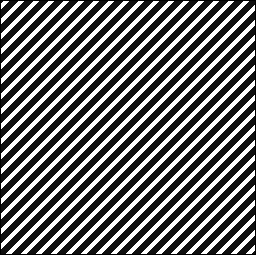

In [75]:
filename = "stp1.gif"
path_input_im1 = os.path.join(folder_path, filename)
im1 = Image.open(path_input_im1)
im1


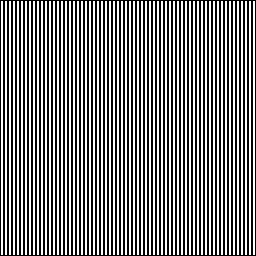

In [76]:
filename = "stp2.gif"
path_input_im2 = os.path.join(folder_path, filename)
im2 = Image.open(path_input_im2)
im2


In [77]:
im1np = np.array(im1.convert('L'))
im2np = np.array(im2.convert('L'))

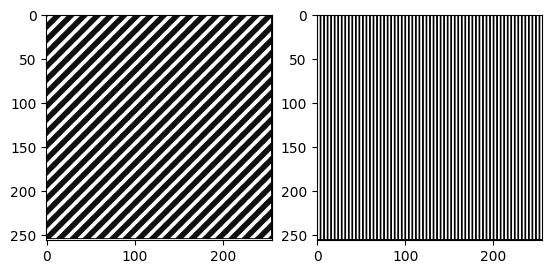

In [78]:
fig, ax = plt.subplots(1, 2)  # создаем фигуру с двумя подграфиками
ax[0].imshow(im1np)
ax[1].imshow(im2np)

## Code

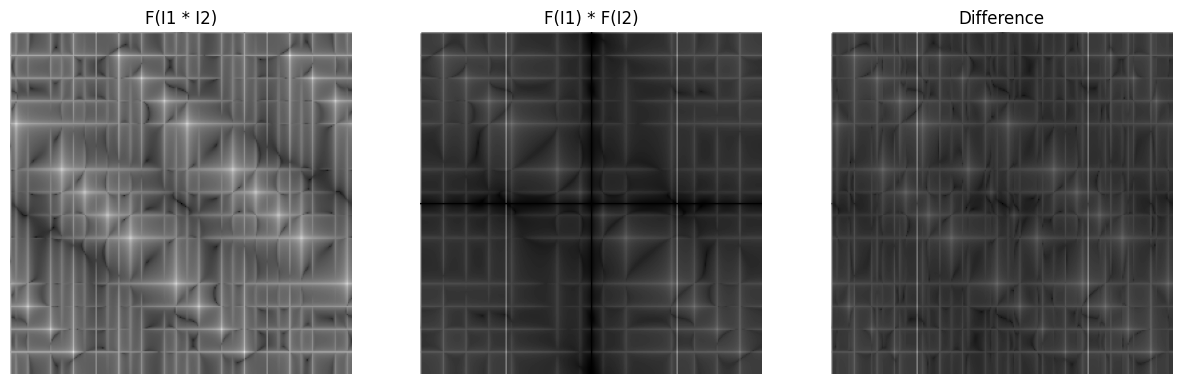

In [82]:
# Вычисление прямого преобразования Фурье каждого изображения
F1 = fft2(im1np)
F2 = fft2(im2np)

# Вычисление прямого преобразования Фурье произведения изображений
F_product = fft2(im1np * im2np)

# Вычисление произведения преобразований Фурье
F1_F2_product = F1 * F2

# Сравнение результатов
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(np.log(np.abs(F_product) + 1), cmap='gray')
axs[0].set_title('F(I1 * I2)')
axs[0].axis('off')

axs[1].imshow(np.log(np.abs(F1_F2_product) + 1), cmap='gray')
axs[1].set_title('F(I1) * F(I2)')
axs[1].axis('off')

axs[2].imshow(np.log(np.abs(F_product - F1_F2_product) + 1), cmap='gray')
axs[2].set_title('Difference')
axs[2].axis('off')

plt.show()

# Ex Question 7 The frequency filters

апишите сглаженные версии фильтров, так чтобы переход от 0 к 1 был как-то плавным. Для тех же значений r и R, сравните резкие и плавные фильтры и прокомментируйте возможное влияние на результат.

для сглаживания используются функции, такие как сигмоид или Гауссово ядро, которые позволяют плавно перейти от одного уровня к другому.

-- Реализация Низкочастотного Фильтра:
- Резкий Фильтр: Фильтр устанавливает значение 1 внутри круга радиусом r и 0 вне его.
- Сглаженный Фильтр: Вместо резкого перехода, используйте функцию сглаживания для плавного перехода значений фильтра от 1 к 0 на границе r.

-- Реализация Высокочастотного Фильтра:
- Резкий Фильтр: Фильтр устанавливает значение 1 вне круга радиусом R и 0 внутри него.
- Сглаженный Фильтр: Аналогично,  функцию сглаживания на границе R для плавного перехода.

Сглаженный Фильтр: Вместо резкого перехода, используйте функцию

## Testing

In [83]:
import numpy as np
import matplotlib.pyplot as plt

In [84]:
def create_smooth_lowpass_filter(shape, r, transition_width=10):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center_col)**2 + (y - center_row)**2)

    # Сглаживание с использованием функции сигмоида
    filter = 1 / (1 + np.exp((distance - r) / transition_width))

    return filter

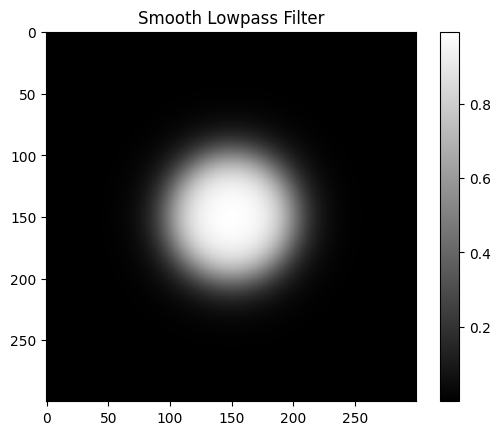

In [85]:
# Параметры фильтра
shape = (300, 300)
r = 50

# Создание фильтра
smooth_filter = create_smooth_lowpass_filter(shape, r)

# Визуализация
plt.imshow(smooth_filter, cmap='gray')
plt.title('Smooth Lowpass Filter')
plt.colorbar()
plt.show()

## Def Sharp and Smooth highpass_filter

In [86]:
def create_sharp_highpass_filter(shape, R):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center_col)**2 + (y - center_row)**2)
    filter = np.array(distance >= R, dtype=int)
    return filter

In [89]:
def create_smooth_highpass_filter(shape, R, transition_width=10):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center_col)**2 + (y - center_row)**2)

    # Сглаживание с использованием функции сигмоида
    filter = 1 / (1 + np.exp(-(distance - R) / transition_width))

    return filter

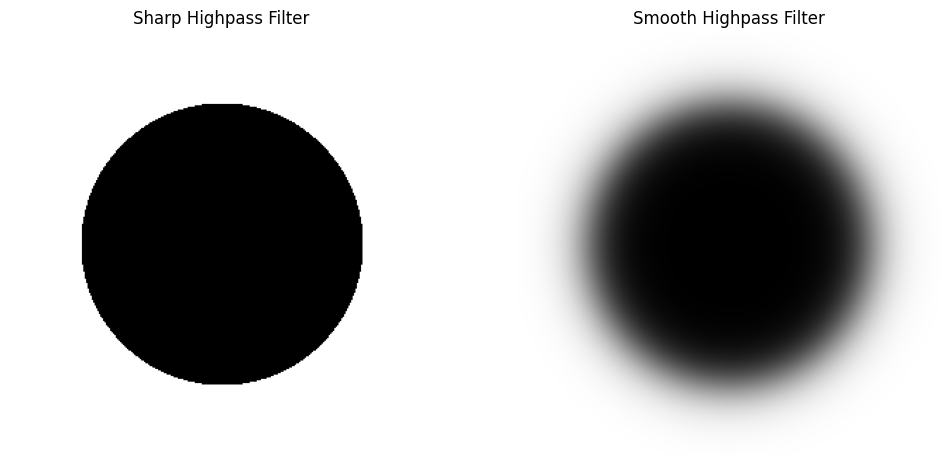

In [90]:
# Параметры фильтра
shape = (300, 300)
R = 100  # Радиус для высокочастотного фильтра

# Создание фильтров
sharp_filter = create_sharp_highpass_filter(shape, R)
smooth_filter = create_smooth_highpass_filter(shape, R)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(sharp_filter, cmap='gray')
axs[0].set_title('Sharp Highpass Filter')
axs[0].axis('off')

axs[1].imshow(smooth_filter, cmap='gray')
axs[1].set_title('Smooth Highpass Filter')
axs[1].axis('off')

plt.show()

## Def Sharp and Smooth low_filter

In [91]:
def create_sharp_lowpass_filter(shape, r):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center_col)**2 + (y - center_row)**2)
    filter = np.array(distance <= r, dtype=int)
    return filter

In [92]:
def create_smooth_lowpass_filter(shape, r, transition_width=10):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center_col)**2 + (y - center_row)**2)

    # Сглаживание с использованием функции сигмоида
    filter = 1 / (1 + np.exp((distance - r) / transition_width))

    return filter

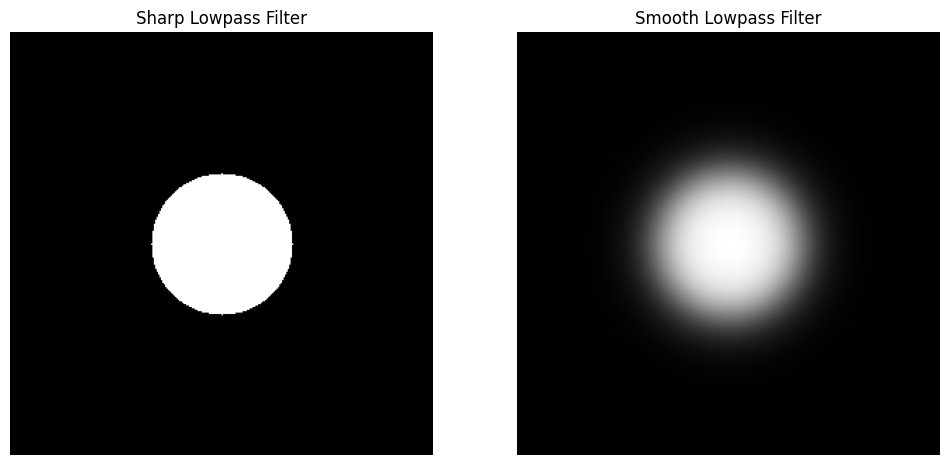

In [93]:
# Параметры фильтра
shape = (300, 300)
r = 50  # Радиус для низкочастотного фильтра

# Создание фильтров
sharp_filter = create_sharp_lowpass_filter(shape, r)
smooth_filter = create_smooth_lowpass_filter(shape, r)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(sharp_filter, cmap='gray')
axs[0].set_title('Sharp Lowpass Filter')
axs[0].axis('off')

axs[1].imshow(smooth_filter, cmap='gray')
axs[1].set_title('Smooth Lowpass Filter')
axs[1].axis('off')

plt.show()

# Ex Question 8 watermarking

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift
from imageio import imread
import pickle

## Load Images

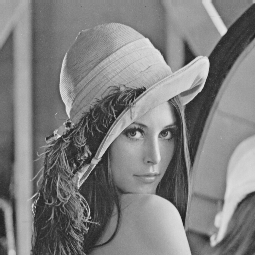

In [94]:
filename = "lena255.pgm"
path_input_im1 = os.path.join(folder_path, filename)
original = Image.open(path_input_im1)
original


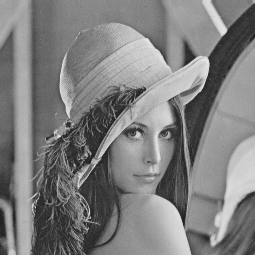

In [95]:
filename = "a.pgm"
path_input_im2 = os.path.join(folder_path, filename)
img_a = Image.open(path_input_im2)
img_a


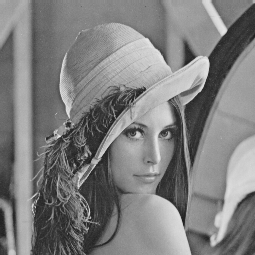

In [97]:
filename = "b.pgm"
path_input_im3 = os.path.join(folder_path, filename)
img_b = Image.open(path_input_im3)
img_b


In [101]:
# Загрузка индексов для водяного знака
with open('./Lab3/imgs-P3/positions.p', 'rb') as file:
    indices = pickle.load(file)

## Start Test

In [102]:
# Преобразование Фурье
F_original = fftshift(fft2(original))
F_a = fftshift(fft2(img_a))
F_b = fftshift(fft2(img_b))

In [103]:
# Анализ частотных спектров
def check_watermark(F_img, F_orig, indices):
    watermark_strength = np.abs(F_img[indices] - F_orig[indices])
    return watermark_strength.mean()

In [104]:
strength_a = check_watermark(F_a, F_original, indices)
strength_b = check_watermark(F_b, F_original, indices)

In [105]:
print(f"Average watermark strength in image A: {strength_a}")
print(f"Average watermark strength in image B: {strength_b}")

# Вывод на основе сравнения
if strength_a > strength_b:
    print("Image A is more likely to have the watermark.")
else:
    print("Image B is more likely to have the watermark.")

Average watermark strength in image A: 116.88687585525267
Average watermark strength in image B: 112.81098152264727
Image A is more likely to have the watermark.
